Meeting 12.02.2025

Work done since last week:
1. Adjustable autoencoder made, and tested on 
- normalized brain data, 
- augmented data, 
- diffent layer combinations, 
- filter size,
- kernel size, 
- latent_dim size, 
- metrics, 
- vae_model vs vae, 

TODO:
- skip connections
- unflatten latent space?
- vae fix bug
- test on more kernel size,  (16, (3,3,3)) -> 

2. Preprocessing questions

- Q1: Genetic algos for evolving networks/autoencoders so one doesn't have to manually try combinations/configurations?
- A1: It may be easier to start with no compression, (1 layer), and just make that good before you compress and add mroe layers..

- Q2: Preprocessing with FSL is taking ages and the input data all is of different rotations, shapes, and the head is also tilted wrongly, spatial normalization on the entire input head still procudes varying results, making us dependent on stripping first the neck, then the top of the skull before performing spatial normalization. Given the big variance in the input data, one is left with cutting some of the brain or leaving some of the neck in the images.
- A2: Highly recommend synthstrip.

3. Remember, we're doing UNSUPERVISED, no random forests, none of that, just
- preprocess
- compare existing encoder models
- see if you can improve some of them (trial and error)
- remove decoder
- plot up a visual representation of the latent space for all images and see if you can distinguish normal brains from AD, MCI spatially.

As of 13.02.2025

In [1]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import math
import numpy as np

from scipy.ndimage import zoom

In [ ]:
# website: https://surfer.nmr.mgh.harvard.edu/docs/synthstrip/
# TRAIN OF TODAYS HATE
# 1. RAN IN CONSOLE: wget https://surfer.nmr.mgh.harvard.edu/pub/dist/freesurfer/synthstrip/models/synthstrip.1.pt -O synthstrip.1.pt, nope..
# 2. Downloaded freerider from github
# 3. Tried banging my heat at the wall figuring out how to run this in .py without any guide whatsoever anywhere??
# 4. Gave up, used docker (WSL)
#  - WSL console: curl -O https://raw.githubusercontent.com/freesurfer/freesurfer/dev/mri_synthstrip/synthstrip-docker && chmod +x synthstrip-docker 
#  - WSL console: ./synthstrip-docker /path/to/your/images

How to reproduce results

In [ ]:

# Website: https://surfer.nmr.mgh.harvard.edu/docs/synthstrip/

# cmd: curl -O https://raw.githubusercontent.com/freesurfer/freesurfer/dev/mri_synthstrip/synthstrip-docker && chmod +x synthstrip-docker

In [ ]:
# Skull removal
# cd "/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/_test0" # cd into the folder above
input_folder="NORMAL0"
output_folder="NORMAL1"

mkdir -p "$output_folder"  # Ensure output folder exists

for file in "$input_folder"/*.nii.gz; do
    filename=$(basename "$file")  # Extract the filename
    output_file="$output_folder/${filename%.nii.gz}2.nii.gz"  # Rename output
    echo "Processing: $file -> $output_file"
    ./synthstrip-docker -i "$file" -o "$output_file"
done

In [ ]:
# Spatial normalization
INPUT_DIR="/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/_test0/AD1"
OUTPUT_DIR="/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/_test0/AD2"
TEMPLATE="/mnt/c/Users/kiran/Documents/_UIS/sem6/BACH/Data/very_good_cuts_fc/105_sub-ADNI007S6310_ses-M000_T1w_brain_brain_restore.nii.gz"
mkdir -p "$OUTPUT_DIR"

process_file() {
    FILE="$1"
    BASENAME=$(basename "$FILE" .nii.gz)
    echo "Processing file: $FILE"
    echo "Base name: $BASENAME"


    flirt -in "$FILE" -ref "$TEMPLATE" -out "$OUTPUT_DIR/${BASENAME}_norm.nii.gz"

}

export -f process_file  # Export the function for parallel execution
find "$INPUT_DIR" -maxdepth 1 -type f -name "*.nii.gz" | while read FILE; do process_file "$FILE"; done

In [2]:
def plot_middle_slices_in_range(folder_path, n1, n2, axis=1, fig_size=(10,10)):
    "# Function to plot the middle slices of images between n1 and n2 in a single figure"
    # Get a sorted list of all files in the directory excluding mask files
    all_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith('.nii.gz') and not f.endswith('_mask.nii.gz')]
    )
    
    # Filter files between n1 and n2
    selected_files = all_files[n1:n2]
    num_images = len(selected_files)
    
    # Determine grid size for the plot
    cols = math.ceil(math.sqrt(num_images))  # Number of columns in the grid
    rows = math.ceil(num_images / cols)  # Number of rows in the grid
    
    # Create a figure for plotting
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)
    axes = axes.flatten()  # Flatten to easily iterate over axes
    
    for i, file in enumerate(selected_files):
        file_path = os.path.join(folder_path, file)
        
        # Load the NIfTI file
        img = nib.load(file_path)
        img_data = img.get_fdata()
        
        # Calculate the middle index along axis 0
        middle_index = img_data.shape[axis] // 2
        
        # Plot the middle slice on the current axis
        axes[i].imshow(img_data[middle_index, :, :].T, cmap='gray', origin="lower")
        axes[i].set_title(file_path.split("\\")[-1].split("_")[0], fontsize=8)
        axes[i].axis('off')
    
    # Hide unused axes if the grid is larger than the number of images
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

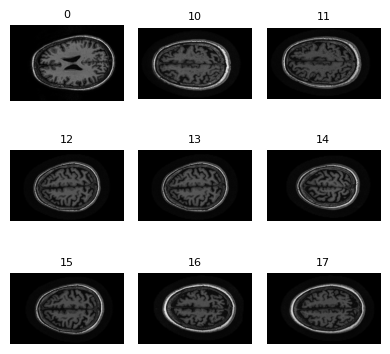

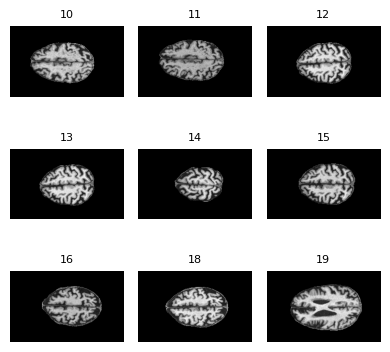

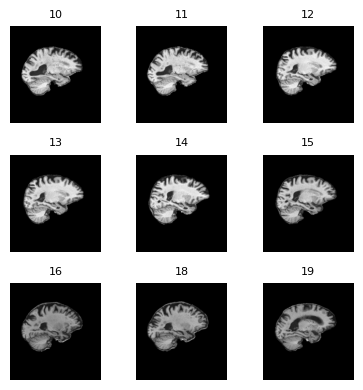

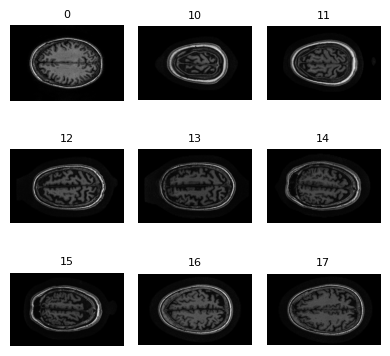

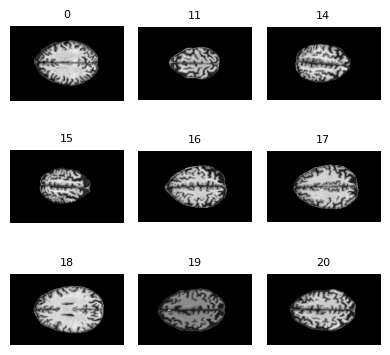

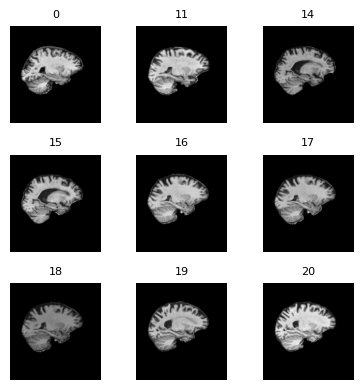

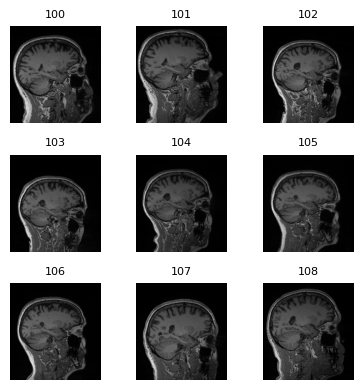

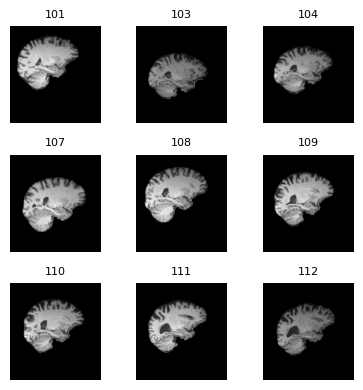

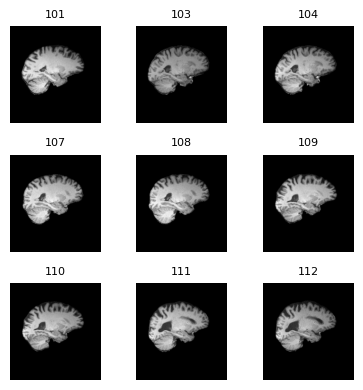

In [3]:
plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\AD0", 0, 9, 2, fig_size=(4,4))
plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\AD1", 0, 9, 2, fig_size=(4,4))
plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\AD2", 0, 9, 2, fig_size=(4,4))

plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\MCI0", 0, 9, 2, fig_size=(4,4))
plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\MCI1", 0, 9, 2, fig_size=(4,4))
plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\MCI2", 0, 9, 2, fig_size=(4,4))

plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\NORMAL0", 0, 9, 2, fig_size=(4,4))
plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\NORMAL1", 0, 9, 2, fig_size=(4,4))
plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\NORMAL2", 0, 9, 2, fig_size=(4,4))

In [ ]:
def plot_average_brain(path = r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\AD0", take=100, target_shape=(256, 256, 170), figsize=(6, 2)):
    # Load all brains in folder path
    brains = []
    for file_name in os.listdir(path):
        if file_name.endswith('.nii.gz'):
            file_path = os.path.join(path, file_name)
            img = nib.load(file_path)
            data = img.get_fdata()
            brains.append(data)

            print(file_name[0:10], end="|")
            if len(brains) > 100:
                break

    # Images are of different shape, so we resize to convert to a numpy array
    resized_brains = [zoom(brain, 
                        (target_shape[0] / brain.shape[0], 
                            target_shape[1] / brain.shape[1], 
                            target_shape[2] / brain.shape[2]))
                    for brain in brains[:take]]
    brains = np.array(resized_brains)

    lateral_index = brains.shape[1] // 2
    top_down_index = int(brains.shape[3] * 0.6)
    front_index = int(brains.shape[2] * 0.4)

    mean_lateral = np.mean(brains[:, lateral_index, :, :], axis=0)
    mean_top_down = np.mean(brains[:, :, :, top_down_index], axis=0)
    mean_front = np.mean(brains[:, :, front_index, :], axis=0)

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes[0].imshow(mean_lateral.T, cmap='gray', origin="lower")
    axes[0].set_title("Lateral View (Sagittal)")
    axes[0].axis('off')

    axes[1].imshow(mean_top_down, cmap='gray')
    axes[1].set_title("Top-Down View (Axial)")
    axes[1].axis('off')

    axes[2].imshow(mean_front.T, cmap='gray', origin="lower")
    axes[2].set_title("Front View (Coronal)")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()
    return mean_lateral.T, mean_top_down, mean_front.T
H_mean_lateral, H_mean_top_down, H_mean_front = plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\NORMAL2", take=100, target_shape=(104, 120, 128), figsize=(6,2))

0_ADNI_002|10_ADNI_02|11_ADNI_02|12_ADNI_02|13_ADNI_02|14_ADNI_02|15_ADNI_02|16_ADNI_02|17_ADNI_02|18_ADNI_02|19_ADNI_02|1_ADNI_002|20_ADNI_02|21_ADNI_02|22_ADNI_02|23_ADNI_02|24_ADNI_02|25_ADNI_02|26_ADNI_02|27_ADNI_02|28_ADNI_03|29_ADNI_03|2_ADNI_002|30_ADNI_03|31_ADNI_13|32_ADNI_13|33_ADNI_13|3_ADNI_005|4_ADNI_005|5_ADNI_005|6_ADNI_012|7_ADNI_012|8_ADNI_023|9_ADNI_023|

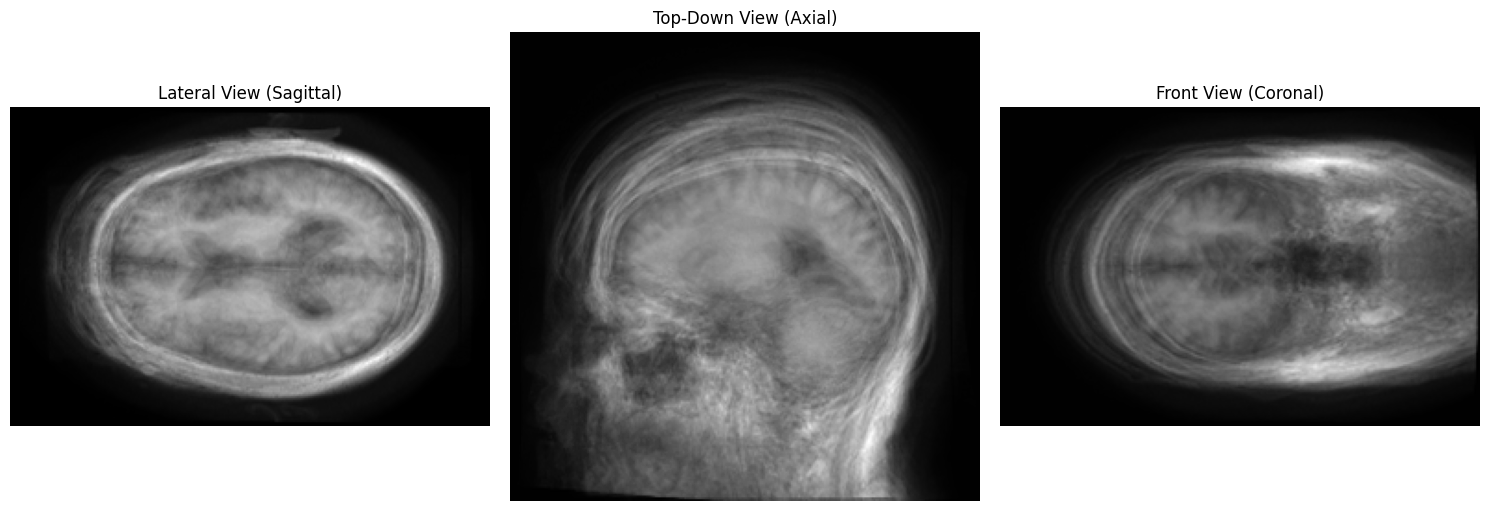

10_ADNI_02|11_ADNI_02|12_ADNI_02|13_ADNI_02|14_ADNI_02|15_ADNI_02|16_ADNI_02|18_ADNI_02|19_ADNI_02|20_ADNI_02|21_ADNI_02|22_ADNI_02|23_ADNI_02|24_ADNI_02|25_ADNI_02|26_ADNI_02|27_ADNI_02|28_ADNI_03|29_ADNI_03|2_ADNI_002|30_ADNI_03|3_ADNI_005|4_ADNI_005|5_ADNI_005|8_ADNI_023|9_ADNI_023|

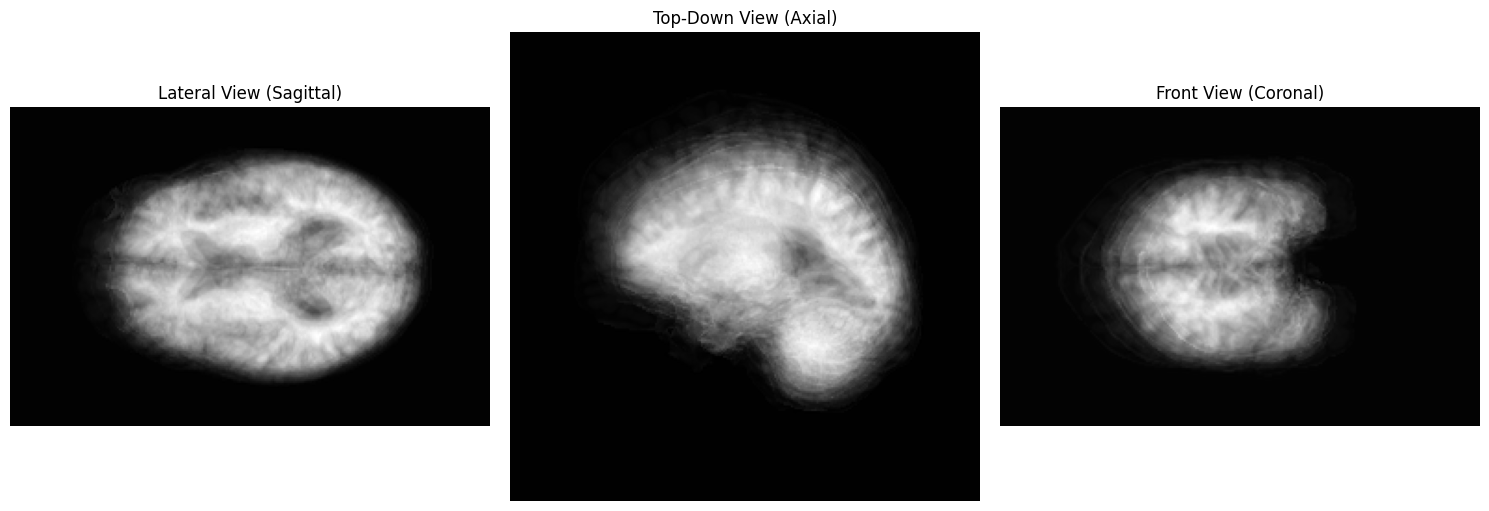

10_ADNI_02|11_ADNI_02|12_ADNI_02|13_ADNI_02|14_ADNI_02|15_ADNI_02|16_ADNI_02|18_ADNI_02|19_ADNI_02|20_ADNI_02|21_ADNI_02|22_ADNI_02|23_ADNI_02|24_ADNI_02|25_ADNI_02|26_ADNI_02|27_ADNI_02|28_ADNI_03|29_ADNI_03|2_ADNI_002|30_ADNI_03|3_ADNI_005|4_ADNI_005|5_ADNI_005|8_ADNI_023|9_ADNI_023|

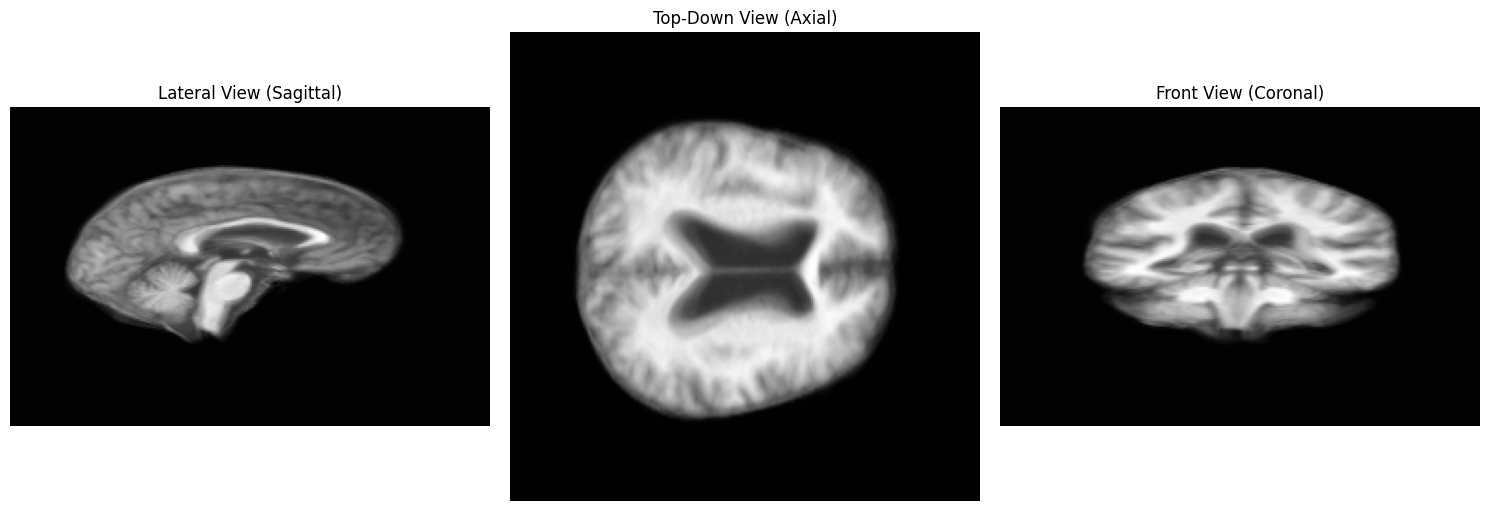

0_ADNI_002|10_ADNI_00|11_ADNI_00|12_ADNI_00|13_ADNI_00|14_ADNI_00|15_ADNI_00|16_ADNI_01|17_ADNI_01|18_ADNI_01|19_ADNI_01|1_ADNI_002|20_ADNI_01|21_ADNI_01|22_ADNI_01|23_ADNI_01|24_ADNI_01|25_ADNI_02|26_ADNI_02|27_ADNI_02|28_ADNI_02|29_ADNI_02|2_ADNI_002|30_ADNI_02|31_ADNI_02|32_ADNI_02|33_ADNI_02|34_ADNI_02|35_ADNI_02|36_ADNI_02|37_ADNI_02|38_ADNI_02|39_ADNI_02|3_ADNI_002|40_ADNI_02|41_ADNI_02|42_ADNI_02|43_ADNI_02|44_ADNI_02|45_ADNI_02|46_ADNI_02|47_ADNI_02|48_ADNI_02|49_ADNI_02|4_ADNI_002|50_ADNI_03|51_ADNI_03|52_ADNI_03|53_ADNI_03|54_ADNI_03|55_ADNI_03|56_ADNI_13|57_ADNI_13|58_ADNI_13|5_ADNI_002|6_ADNI_002|7_ADNI_002|8_ADNI_002|9_ADNI_002|

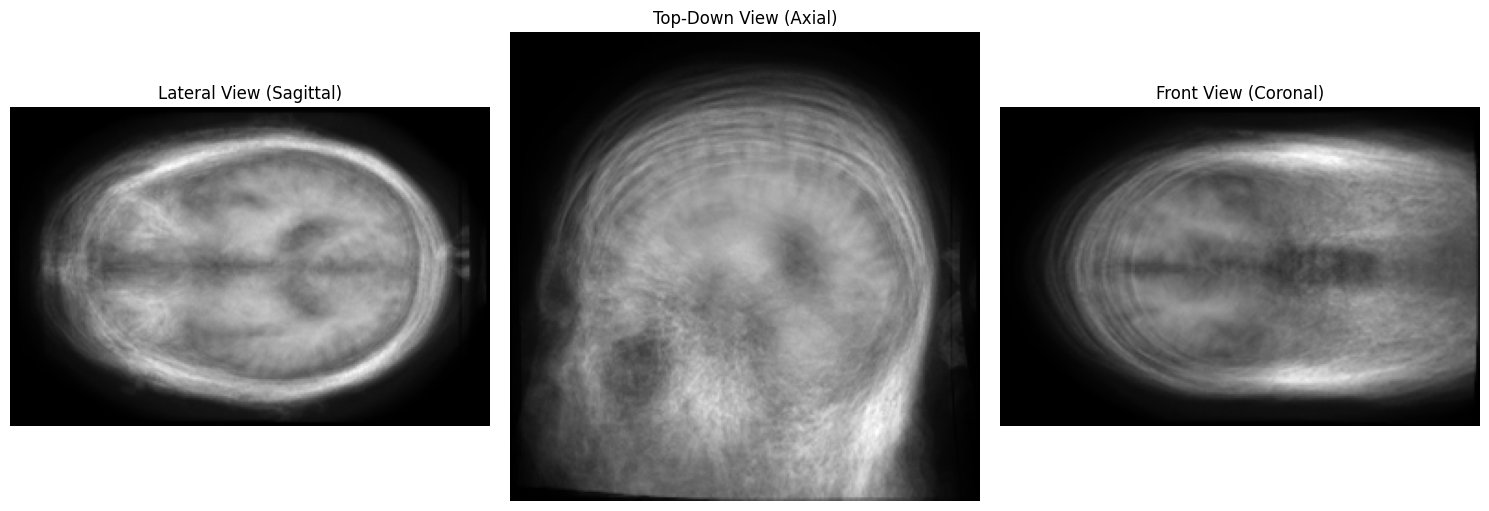

0_ADNI_002|11_ADNI_00|14_ADNI_00|15_ADNI_00|16_ADNI_01|17_ADNI_01|18_ADNI_01|19_ADNI_01|20_ADNI_01|21_ADNI_01|22_ADNI_01|23_ADNI_01|24_ADNI_01|25_ADNI_02|26_ADNI_02|27_ADNI_02|28_ADNI_02|29_ADNI_02|30_ADNI_02|31_ADNI_02|32_ADNI_02|33_ADNI_02|34_ADNI_02|35_ADNI_02|36_ADNI_02|37_ADNI_02|38_ADNI_02|39_ADNI_02|40_ADNI_02|41_ADNI_02|42_ADNI_02|43_ADNI_02|44_ADNI_02|45_ADNI_02|46_ADNI_02|47_ADNI_02|49_ADNI_02|50_ADNI_03|51_ADNI_03|52_ADNI_03|53_ADNI_03|54_ADNI_03|55_ADNI_03|57_ADNI_13|6_ADNI_002|9_ADNI_002|

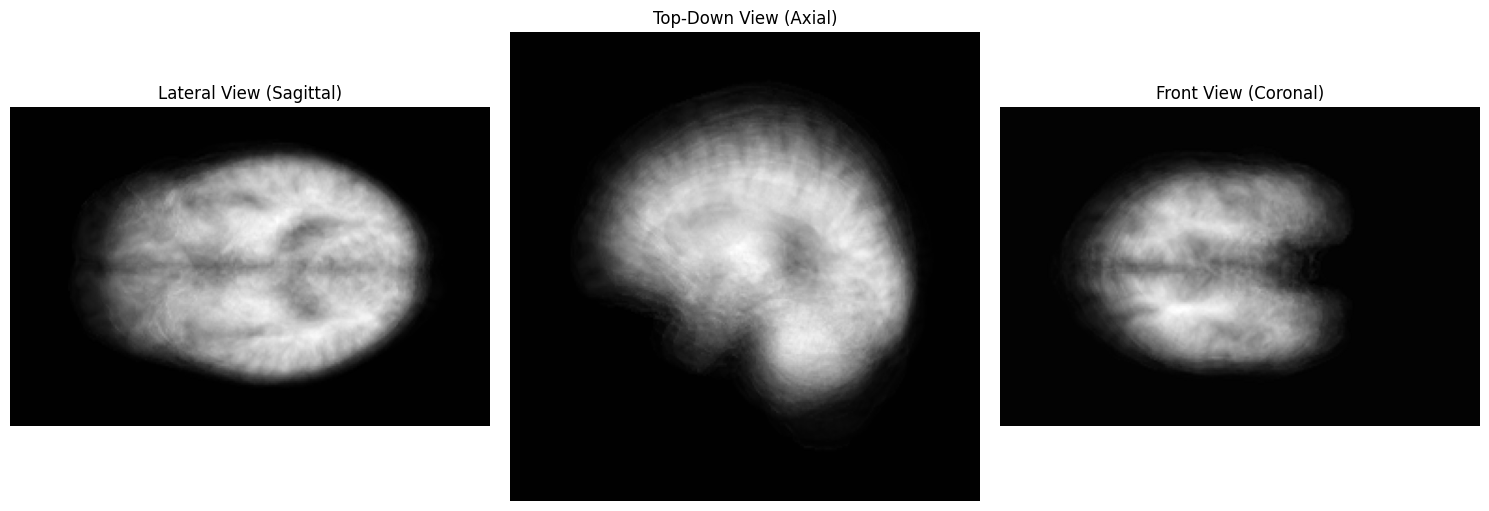

0_ADNI_002|11_ADNI_00|14_ADNI_00|15_ADNI_00|16_ADNI_01|17_ADNI_01|18_ADNI_01|19_ADNI_01|20_ADNI_01|21_ADNI_01|22_ADNI_01|23_ADNI_01|24_ADNI_01|25_ADNI_02|26_ADNI_02|27_ADNI_02|28_ADNI_02|29_ADNI_02|30_ADNI_02|31_ADNI_02|32_ADNI_02|33_ADNI_02|34_ADNI_02|35_ADNI_02|36_ADNI_02|37_ADNI_02|38_ADNI_02|39_ADNI_02|40_ADNI_02|41_ADNI_02|42_ADNI_02|43_ADNI_02|44_ADNI_02|45_ADNI_02|46_ADNI_02|47_ADNI_02|49_ADNI_02|50_ADNI_03|51_ADNI_03|52_ADNI_03|53_ADNI_03|54_ADNI_03|55_ADNI_03|57_ADNI_13|6_ADNI_002|9_ADNI_002|

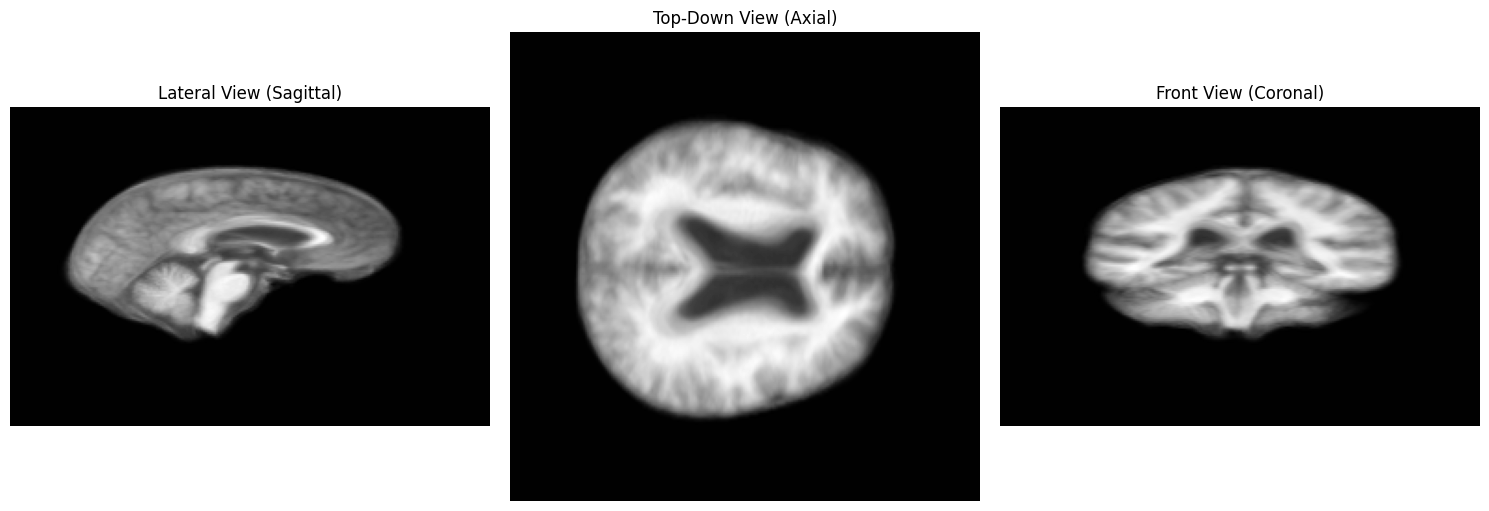

100_sub-AD|101_sub-AD|102_sub-AD|103_sub-AD|104_sub-AD|105_sub-AD|106_sub-AD|107_sub-AD|108_sub-AD|109_sub-AD|110_sub-AD|111_sub-AD|112_sub-AD|113_sub-AD|114_sub-AD|115_sub-AD|116_sub-AD|117_sub-AD|118_sub-AD|119_sub-AD|11_sub-ADN|120_sub-AD|121_sub-AD|122_sub-AD|123_sub-AD|124_sub-AD|125_sub-AD|126_sub-AD|12_sub-ADN|14_sub-ADN|16_sub-ADN|17_sub-ADN|181_sub-AD|182_sub-AD|183_sub-AD|184_sub-AD|185_sub-AD|186_sub-AD|187_sub-AD|188_sub-AD|189_sub-AD|18_sub-ADN|190_sub-AD|191_sub-AD|192_sub-AD|193_sub-AD|194_sub-AD|195_sub-AD|198_sub-AD|199_sub-AD|19_sub-ADN|1_sub-ADNI|200_sub-AD|201_sub-AD|202_sub-AD|203_sub-AD|204_sub-AD|205_sub-AD|206_sub-AD|207_sub-AD|208_sub-AD|209_sub-AD|20_sub-ADN|210_sub-AD|211_sub-AD|212_sub-AD|213_sub-AD|216_sub-AD|218_sub-AD|219_sub-AD|21_sub-ADN|220_sub-AD|221_sub-AD|222_sub-AD|224_sub-AD|225_sub-AD|226_sub-AD|227_sub-AD|228_sub-AD|229_sub-AD|22_sub-ADN|230_sub-AD|231_sub-AD|232_sub-AD|233_sub-AD|234_sub-AD|235_sub-AD|236_sub-AD|237_sub-AD|238_sub-AD|239_sub-AD

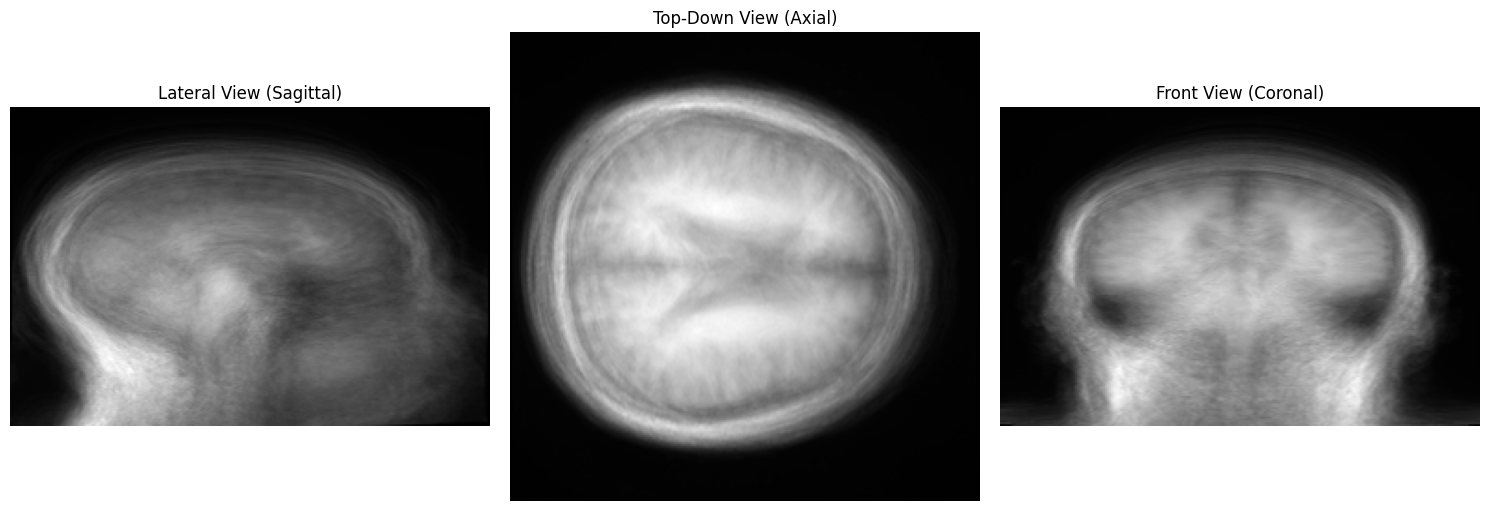

101_sub-AD|103_sub-AD|104_sub-AD|107_sub-AD|108_sub-AD|109_sub-AD|110_sub-AD|111_sub-AD|112_sub-AD|113_sub-AD|114_sub-AD|115_sub-AD|116_sub-AD|117_sub-AD|118_sub-AD|120_sub-AD|121_sub-AD|122_sub-AD|123_sub-AD|124_sub-AD|125_sub-AD|16_sub-ADN|17_sub-ADN|182_sub-AD|183_sub-AD|184_sub-AD|185_sub-AD|187_sub-AD|188_sub-AD|189_sub-AD|18_sub-ADN|190_sub-AD|193_sub-AD|194_sub-AD|195_sub-AD|19_sub-ADN|1_sub-ADNI|200_sub-AD|201_sub-AD|202_sub-AD|203_sub-AD|205_sub-AD|206_sub-AD|207_sub-AD|209_sub-AD|20_sub-ADN|210_sub-AD|212_sub-AD|213_sub-AD|216_sub-AD|218_sub-AD|21_sub-ADN|220_sub-AD|221_sub-AD|222_sub-AD|224_sub-AD|225_sub-AD|226_sub-AD|227_sub-AD|228_sub-AD|229_sub-AD|22_sub-ADN|230_sub-AD|231_sub-AD|232_sub-AD|233_sub-AD|234_sub-AD|236_sub-AD|237_sub-AD|23_sub-ADN|240_sub-AD|241_sub-AD|242_sub-AD|244_sub-AD|245_sub-AD|248_sub-AD|250_sub-AD|253_sub-AD|255_sub-AD|257_sub-AD|258_sub-AD|259_sub-AD|261_sub-AD|264_sub-AD|265_sub-AD|266_sub-AD|267_sub-AD|26_sub-ADN|270_sub-AD|271_sub-AD|272_sub-AD

In [ ]:
plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\AD0", figsize=(6,2))
plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\AD1", figsize=(6,2))
plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\AD2", figsize=(6,2))

plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\MCI0", figsize=(6,2))
plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\MCI1", figsize=(6,2))
plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\MCI2", figsize=(6,2))

plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\NORMAL0", figsize=(6,2))
plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\NORMAL1", figsize=(6,2))
#plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\NORMAL2", figsize=(6,2))

10_ADNI_02|11_ADNI_02|12_ADNI_02|13_ADNI_02|14_ADNI_02|15_ADNI_02|16_ADNI_02|18_ADNI_02|19_ADNI_02|20_ADNI_02|21_ADNI_02|22_ADNI_02|23_ADNI_02|24_ADNI_02|25_ADNI_02|26_ADNI_02|27_ADNI_02|28_ADNI_03|29_ADNI_03|2_ADNI_002|30_ADNI_03|3_ADNI_005|4_ADNI_005|5_ADNI_005|8_ADNI_023|9_ADNI_023|

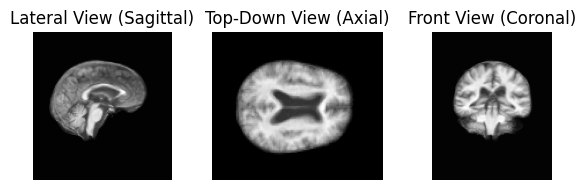

101_sub-AD|103_sub-AD|104_sub-AD|107_sub-AD|108_sub-AD|109_sub-AD|110_sub-AD|111_sub-AD|112_sub-AD|113_sub-AD|114_sub-AD|115_sub-AD|116_sub-AD|117_sub-AD|118_sub-AD|120_sub-AD|121_sub-AD|122_sub-AD|123_sub-AD|124_sub-AD|125_sub-AD|16_sub-ADN|17_sub-ADN|182_sub-AD|183_sub-AD|184_sub-AD|185_sub-AD|187_sub-AD|188_sub-AD|189_sub-AD|18_sub-ADN|190_sub-AD|193_sub-AD|194_sub-AD|195_sub-AD|19_sub-ADN|1_sub-ADNI|200_sub-AD|201_sub-AD|202_sub-AD|203_sub-AD|205_sub-AD|206_sub-AD|207_sub-AD|209_sub-AD|20_sub-ADN|210_sub-AD|212_sub-AD|213_sub-AD|216_sub-AD|218_sub-AD|21_sub-ADN|220_sub-AD|221_sub-AD|222_sub-AD|224_sub-AD|225_sub-AD|226_sub-AD|227_sub-AD|228_sub-AD|229_sub-AD|22_sub-ADN|230_sub-AD|231_sub-AD|232_sub-AD|233_sub-AD|234_sub-AD|236_sub-AD|237_sub-AD|23_sub-ADN|240_sub-AD|241_sub-AD|242_sub-AD|244_sub-AD|245_sub-AD|248_sub-AD|250_sub-AD|253_sub-AD|255_sub-AD|257_sub-AD|258_sub-AD|259_sub-AD|261_sub-AD|264_sub-AD|265_sub-AD|266_sub-AD|267_sub-AD|26_sub-ADN|270_sub-AD|271_sub-AD|272_sub-AD

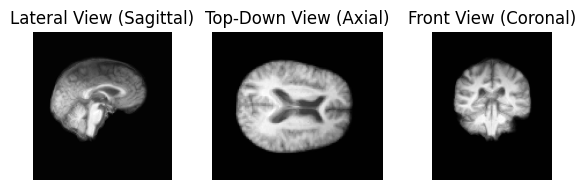

In [ ]:
AD_mean_lateral, AD_mean_top_down, AD_mean_front = plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\AD2", take=100, target_shape=(104, 120, 128), figsize=(6,2))
H_mean_lateral, H_mean_top_down, H_mean_front = plot_average_brain(path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\_test0\NORMAL2", take=100, target_shape=(104, 120, 128), figsize=(6,2))

Highlighting the difference in alzheimers. (The difference being more white)

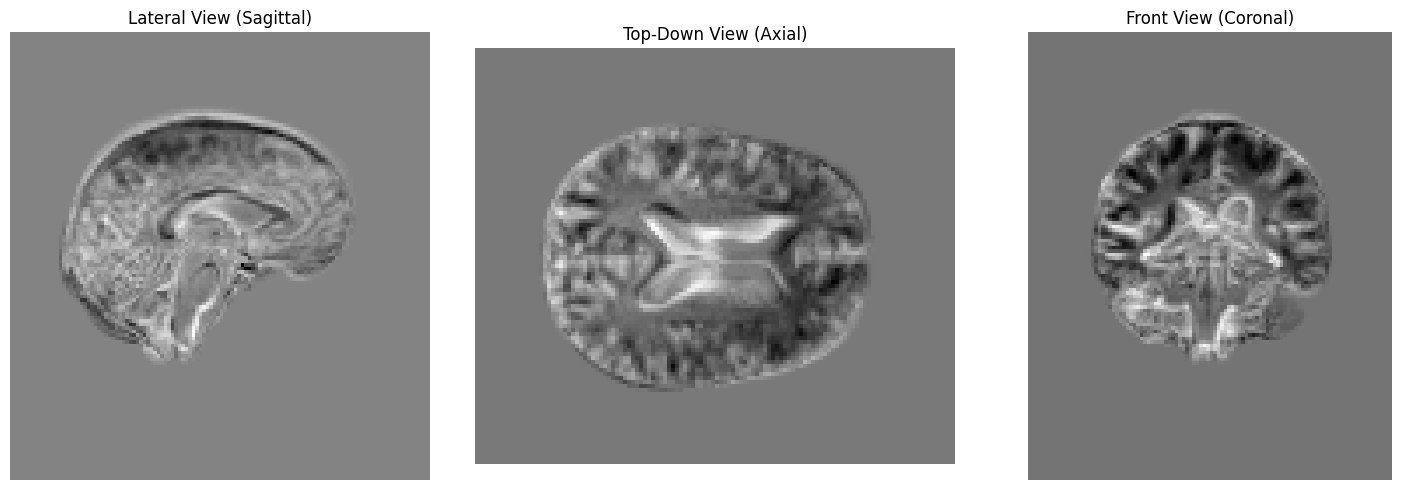

In [ ]:
A,B,C = H_mean_lateral - AD_mean_lateral, H_mean_top_down - AD_mean_top_down, H_mean_front - AD_mean_front

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(A, cmap='gray', origin="lower")
axes[0].set_title("Lateral View (Sagittal)")
axes[0].axis('off')

axes[1].imshow(B, cmap='gray')
axes[1].set_title("Top-Down View (Axial)")
axes[1].axis('off')

axes[2].imshow(C, cmap='gray', origin="lower")
axes[2].set_title("Front View (Coronal)")
axes[2].axis('off')

plt.tight_layout()
plt.show()